## CHEME 5660 Practice Prelim 2 Debt Question

You are a Quant at Olin Financial, an up-and-coming hedge fund. 
You have been tasked with computing the interest rate risk on U.S Treasury bond positions held in your fund;
you hold 10 $\times$ 10-year zero-coupon STRIPs products, each with a face value of 10,000 USD.

__Assumptions__: (i) Olin Financial purchased the bonds at a Treasury auction on 08/18/22 with a spot rate of 2.88\%; (ii) the spot rate on 10/28/22 was 4.02\%; (iii) Olin Financial purchased the bonds at the primary auction at a fair price.

Use the Jupyter notebook `CHEME-5660-PP2-Debt.ipynb` and any associated data sets, to answer the following questions:

* a) What price did Olin Financial pay for the bonds at the Treasury auction on 08/18/22?
* b) If Olin Financial wanted to liquidate their bond position on 10/28/22, what capital gain or loss (assuming fair pricing) would they experience?
* c) Using estimates of future spots rates computed from the [Cox-Ingersoll-Ross (CIR) model](https://en.wikipedia.org/wiki/Cox–Ingersoll–Ross_model), estimate the distribution of bond portfolio values 5-years from now.

## Solution

In [1]:
import Pkg; Pkg.activate("."); Pkg.resolve(); Pkg.instantiate();

  Activating project at `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/prelims/P2/practice`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/prelims/P2/practice/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Markets-Mayhem-Example-Notebooks/prelims/P2/practice/Manifest.toml`


In [2]:
# load external packages that are required for the calculations -
using DataFrames
using CSV
using Dates
using Statistics
using LinearAlgebra
using Plots
using Colors
using Distributions
using StatsPlots

# setup paths to load XYZ OHLC data set -
const _NOTEBOOK_ROOT = pwd();
const _PATH_TO_DATA = joinpath(_NOTEBOOK_ROOT, "data");

In [3]:
include("CHEME-5560-PP2-CodeLib.jl");

In [4]:
# load historical interest rate data -
df = CSV.read(joinpath(_PATH_TO_DATA,"Historical-10-year-treasury-bond-rate-yield-chart.csv"), DataFrame);

In [5]:
# constants -
D = 10;       # 10-year duration for bond
N = 10;       # number of bonds
r̄₁ = 0.0288;  # spot rate when bonds were purchased 08/18/22
r̄₂ = 0.0402;  # spot rate on 10/28/22
F = 10000.0;  # face value of the bond

### a) Initial bond price on 08/18/22?

In [6]:
Vₚ_purchased = (F)/((1+r̄₁)^D);
println("Bond price at auction Vₚ = $(Vₚ_purchased) USD/bond")

Bond price at auction Vₚ = 7528.187793562794 USD/bond


### b) What is the profit (or loss) if Olin liquidated their bond portfolio on 10/28/22?

In [7]:
Vₚ_now = (F)/((1+r̄₂)^D);
println("Bond price at now Vₚ = $(Vₚ_now) USD/bond")

Bond price at now Vₚ = 6742.663800198312 USD/bond


In [8]:
# liquidation value -
PL_now = N*(Vₚ_now - Vₚ_purchased)

-7855.239933644816

### c) Should we hold or sell?

In [9]:
df_recent = filter(:date => x-> (x>=Date(2012,10,31) && x<=Date(2022,10,27)), df);

In [10]:
df_recent

2517×2 DataFrame
  Row │ date        value   
      │ Date        Float64 
──────┼─────────────────────
    1 │ 2012-10-31     1.72
    2 │ 2012-11-01     1.75
    3 │ 2012-11-02     1.75
    4 │ 2012-11-05     1.72
    5 │ 2012-11-06     1.78
    6 │ 2012-11-07     1.68
    7 │ 2012-11-08     1.62
    8 │ 2012-11-09     1.61
    9 │ 2012-11-13     1.59
   10 │ 2012-11-14     1.59
   11 │ 2012-11-15     1.58
  ⋮   │     ⋮          ⋮
 2508 │ 2022-10-14     4.0
 2509 │ 2022-10-17     4.02
 2510 │ 2022-10-18     4.01
 2511 │ 2022-10-19     4.14
 2512 │ 2022-10-20     4.24
 2513 │ 2022-10-21     4.21
 2514 │ 2022-10-24     4.25
 2515 │ 2022-10-25     4.1
 2516 │ 2022-10-26     4.04
 2517 │ 2022-10-27     3.96
           2496 rows omitted

In [11]:
σ = std(df_recent[!,:value])

0.6601302859980128

In [12]:
# setup a CIR training model -
cir_training_model = CIRModel();
cir_training_model.θ = mean(df_recent[!,:value]);
cir_training_model.σ = std(df_recent[!,:value]);
cir_training_model.α = 0.90;
cir_training_model.T₁ = 0.0; 
cir_training_model.T₂ = (length(df_recent[!,:value])/365);
cir_training_model.h = (1/365);
cir_training_model.rₒ = df_recent[1,:value];

In [13]:
# solve the CIR model -
simulation_results = solve(cir_training_model);

In [14]:
T = simulation_results[:,1];
R = simulation_results[:,2:end];

In [15]:
plot(T,R, label="", c=colorant"#BDBBBB");
plot!(T[1:end-1], df_recent[:,:value],lw=3, c=colorant"#EF4035", label="Actual spot rate")

# estimated mean -
μ̂ = mean(R, dims=2)
L = μ̂ .- std(R, dims=2)
U = μ̂ .+ std(R, dims=2)
plot!(T,μ̂, c=colorant"#0068AC", lw=3, label="mean simulated spot rate");
plot!(T,μ̂, c=colorant"#0068AC", fillrange=U, fillalpha = 0.4, lw=2, label="")
plot!(T,μ̂, c=colorant"#0068AC", fillrange=L, fillalpha = 0.4, lw=2, label="")

# setup labels -
xlabel!("Time (years)", fontsize=18)
ylabel!("Estimated spot rate", fontsize=18)

In [16]:
# setup a CIR prediction model -
cir_prediction_model = CIRModel();
cir_prediction_model.θ = mean(df_recent[!,:value]);
cir_prediction_model.σ = std(df_recent[!,:value]);
cir_prediction_model.α = 0.90;
cir_prediction_model.T₁ = 0.0; 
cir_prediction_model.T₂ = 5.0; # 5-years from now
cir_prediction_model.h = (1/365);
cir_prediction_model.rₒ = df_recent[end,:value]; # rate value on 10/28/22

In [17]:
# solve the CIR model -
prediction_results = solve(cir_prediction_model; 𝒫 = 25000);

In [18]:
TP = prediction_results[:,1];
RP = prediction_results[:,2:end];

In [19]:
skip_factor = 250;
plot(TP,RP[:,1:skip_factor:end], label="", c=colorant"#BDBBBB")

# # estimated mean -
μ̂P = mean(RP, dims=2)
LP = μ̂P .- std(RP, dims=2)
UP = μ̂P .+ std(RP, dims=2)
plot!(TP,μ̂P, c=colorant"#0068AC", lw=3, label="mean predicted spot rate");
plot!(TP,μ̂P, c=colorant"#0068AC", fillrange=UP, fillalpha = 0.4, lw=2, label="")
plot!(TP,μ̂P, c=colorant"#0068AC", fillrange=LP, fillalpha = 0.4, lw=2, label="")

# setup labels -
xlabel!("Time (years)", fontsize=18)
ylabel!("Predicted spot rate", fontsize=18)

In [20]:
# compute -
(NR,NP) = size(RP);
V_array = Array{Float64,2}(undef, NP,2);

for i ∈ 1:NP
    
    r_tmp = RP[end,i];
    V_tmp = F/((1+(r_tmp/100))^D)
    V_array[i,1] = r_tmp 
    V_array[i,2] = V_tmp 
end

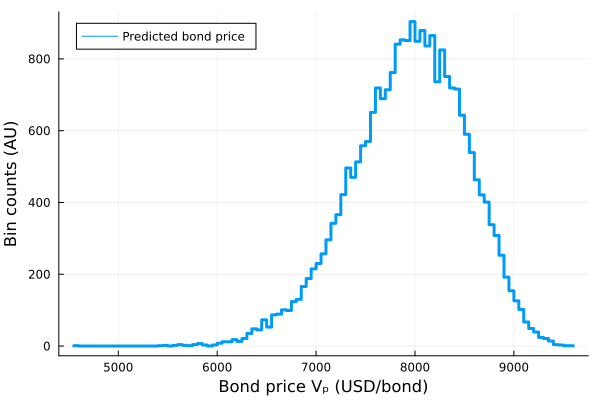

In [21]:
stephist(V_array[:,2], label="Predicted bond price", lw=3, legend=:topleft)
xlabel!("Bond price Vₚ (USD/bond)", fotsize=18)
ylabel!("Bin counts (AU)", fotsize=18)

In [22]:
P_loss = P(V_array[:,2], Vₚ_purchased);
println("Probability of bond portfolio profit: $(1-P_loss)")

Probability of bond portfolio profit: 0.76628


In [23]:
cir_prediction_model

CIRModel(2.1176741756058797, 0.9, 0.6601302859980128, 0.0, 5.0, 0.0027397260273972603, 3.96)